## Calculation of Entropy from Images and Lidar Data

In [1]:
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

import os
import glob

Define the function to calculate the Entropy from a normalized histogram

In [2]:
def entropy(hist):
    entropy = 0
    for i in range(len(hist)):
        if hist[i] > 0:
            entropy -= np.log2(hist[i])*hist[i]
    return entropy

Test the resolution on the Lena image prior to edge detection and after edge detection

In [3]:
im = Image.open('lenagrey.gif')
im.save('lenagrey.png')
im = Image.open('lenacanny.gif')
im.save('lenacanny.png')
im = Image.open('lenacannylowradius.gif')
im.save('lenacannylowradius.png')

img_names = ['lena grey scale', 'lena canny', 'lena canny low radius']
lenagrey = cv2.imread('lenagrey.png')
lenacanny = cv2.imread('lenacanny.png')
lenacannylowradius = cv2.imread('lenacannylowradius.png')

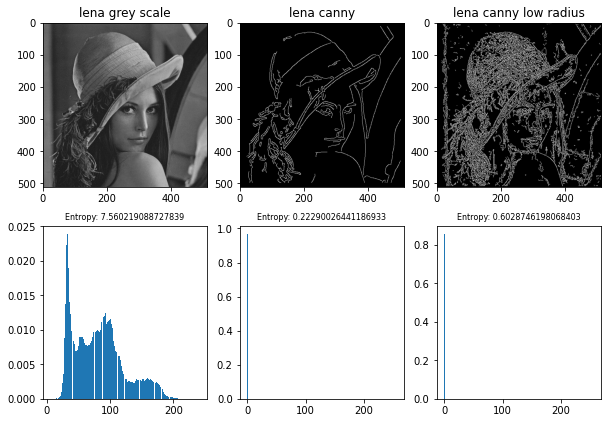

In [4]:
imgs = [lenagrey, lenacanny, lenacannylowradius]
hists = []
e2 = []
fig, axes = plt.subplots(2, 3, figsize=(10,7))
for i, (img, name) in enumerate(zip(imgs, img_names)):
    hist, _, _ = axes[1,i].hist(img.ravel(), bins=256, density=True)
    hist2, _ = np.histogram(img, bins=256, density=True)
    e2.append(entropy(hist2))
    ax2 = axes[0,i]
    ax2.imshow(img)
    ax2.set_title(name)
    e = entropy(hist)
    axes[1,i].set_title('Entropy: ' + str(e), fontsize=8)


plt.show()

In [5]:
print(e2)

[7.560219088727839, 0.22290026441186933, 0.6028746198068403]


In [6]:
import sys
sys.path.append("../") # go to parent dir

### Evaluate the entropy of the Kitty data images

In [7]:
im_dir = '../data/2011_09_26/2011_09_26_drive_0009_sync/image_02/data/'

os.path.exists(im_dir)

True

In [8]:
images = sorted([f for f in glob.glob(im_dir+'*.png', recursive=False)])
len(images)

107

In [9]:
im = cv2.imread(images[0])

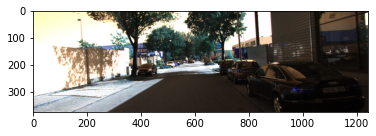

In [10]:
plt.imshow(im)

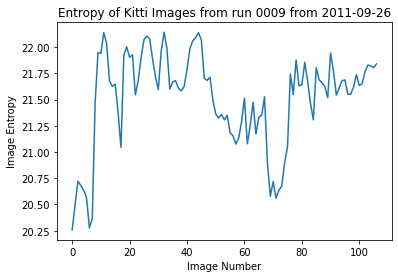

In [11]:
entropies = []
for i, f in enumerate(images):
    im = cv2.imread(images[i])
    e = 0
    for c in range(3):
        im_flat = im[:,:,c].ravel()
        hist, _ = np.histogram(im_flat, bins=256, density=True )
        e += entropy(hist)
    entropies.append(e)
plt.plot(entropies)
plt.title('Entropy of Kitti Images from run 0009 from 2011-09-26')
plt.xlabel('Image Number')
_ = plt.ylabel('Image Entropy')

### Evaluate the Entropy of the Lidar data (Full Resolution)

In [12]:
lidar_dir = '../data/2011_09_26/2011_09_26_drive_0009_sync/velodyne_points/data/'
lidar_f = sorted([f for f in glob.glob(lidar_dir+'*.bin', recursive=False)])


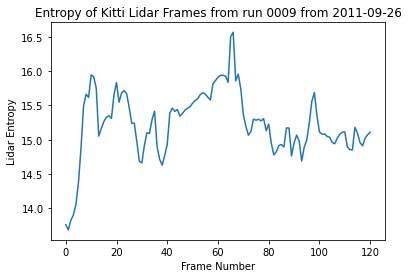

In [13]:
lidar_entropies = []
for i, f in enumerate(lidar_f):    
    vals = np.fromfile(f, dtype = np.float32)
    vals = vals.reshape(len(vals)//4, 4)
    dists = np.sqrt(vals[:,0]**2 + vals[:,1]**2 + vals[:,2]**2)
    hist, _ = np.histogram(dists, bins=256, density=True)
    e = entropy(hist)
    lidar_entropies.append(e)

plt.plot(lidar_entropies)
plt.title('Entropy of Kitti Lidar Frames from run 0009 from 2011-09-26')
plt.xlabel('Frame Number')
_ = plt.ylabel('Lidar Entropy')

### Evaluate the Entropy of the Lidar Data (at different resolutions)

In [14]:
f = lidar_f[0]
vals = np.fromfile(f, dtype = np.float32)
vals = vals.reshape(len(vals)//4, 4)
dists = np.sqrt(vals[:,0]**2 + vals[:,1]**2 + vals[:,2]**2)

In [15]:
downsample_factors = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16284]

In [16]:
entropies = []
for factor in downsample_factors:
    d = dists[::factor]
    print(d.shape)
    hist, _ = np.histogram(d, bins=256, density=True)
    e = entropy(hist)
    entropies.append(e)

(122320,)
(61160,)
(30580,)
(15290,)
(7645,)
(3823,)
(1912,)
(956,)
(478,)
(239,)
(120,)
(60,)
(30,)
(15,)
(8,)


In [17]:
entropies

[13.761492871877286,
 13.759855574466647,
 13.748432135733832,
 13.825364816828092,
 13.79627614428234,
 13.763579224914416,
 13.682594095341518,
 13.918127378990066,
 13.662785840705235,
 13.544208490011947,
 13.023001223222886,
 11.224336448978516,
 9.463479812709812,
 6.924712197027327,
 3.255743778474268]